### Precalculated Tables

We ned to create a service that has all the data for the FE  
Starting with [GADM](https://eowilson.maps.arcgis.com/home/item.html?id=8b830df4fbca4a8388a120dfa13d887b)

In [104]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json 

### Data from CRFS
The data comes from prcessing 4 crfs (one per taxon block) against each geometry of the gadm level 1 table.
The CRFS used for this example are wrong. The crfs are not projected, therefore the assumption we were making that **1 pixel = 1km2** is wrong. The output data of the new crfs should be the same except that they will be equivalent to area.

### GADM level 1 data 
original gadm table from Scott:
gadm feature layer simplified (by Tamara): https://eowilson.maps.arcgis.com/home/item.html?id=4afeb2c82e8a45e98f9c698cb2259dc0

In [177]:
#rept  = pd.read_csv('../../HALF_EARTH/precalc_gadm1_reptiles.zip')
#amph = pd.read_csv('../../HALF_EARTH/precalc_gadm1_amphibians.zip')
mam = pd.read_csv('../../HALF_EARTH/mammals_gadm1_final_kevin.zip') ## old
bird = pd.read_csv('../../HALF_EARTH/birds_gadm1_20210930.zip') ## old
amph = pd.read_csv('../../HALF_EARTH/amphibians_gadm1_final_20211003.zip') ## final
rept = pd.read_csv('../../HALF_EARTH/reptiles_gadm1_final_20211003.zip') ## final

In [238]:
#gadm = gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/gadm36_level1.zip')
gadm = gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/gadm36_level1_Simplify.zip')

### gadm as raster area
gadmpix = pd.read_csv('../../HALF_EARTH/gadm1_polygon_to_raster.csv')

In [240]:
gadmpix.head()

,OID_,Value,Count
0,1,1,43697.0
1,2,2,20581.0
2,3,3,21120.0
3,4,4,17265.0
4,5,5,14173.0


In [241]:
gadm = gadm.merge(gadmpix, right_on = 'Value', left_on = 'MOL_ID')
gadm.rename(columns={'Count':'AREA_PX'}, inplace = True)

In [243]:
gadm.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,AREA_KM2,MOL_ID,InPoly_FID,SimPgnFlag,MaxSimpTol,MinSimpTol,geometry,OID_,Value,AREA_PX
0,AFG,Afghanistan,AFG.1_1,Badakhshan,Badah?an,None,Velayat,Province,None,AF.BD,43692.210235,1,0,0,0.005,0.005,"POLYGON ((71.10155 35.95555, 71.08842 35.92924...",1,1,43697.0
1,AFG,Afghanistan,AFG.2_1,Badghis,Badghes|Badghisat|Badgis,None,Velayat,Province,None,AF.BG,20589.857163,2,1,0,0.005,0.005,"POLYGON ((63.09734 34.64551, 63.06237 34.69018...",2,2,20581.0
2,AFG,Afghanistan,AFG.3_1,Baghlan,Baglan|Bughlan,None,Velayat,Province,None,AF.BL,21120.261382,3,2,0,0.005,0.005,"POLYGON ((67.35538 34.88549, 67.33750 34.91966...",3,3,21120.0
3,AFG,Afghanistan,AFG.4_1,Balkh,Balh|Mazar-i-Sharif|Mazar,None,Velayat,Province,None,AF.BK,17253.634668,4,3,0,0.005,0.005,"POLYGON ((66.42347 35.64057, 66.51625 35.67334...",4,4,17265.0
4,AFG,Afghanistan,AFG.5_1,Bamyan,None,None,Velayat,Province,None,AF.BM,14173.489095,5,4,0,0.005,0.005,"POLYGON ((66.65279 34.00322, 66.67175 34.03791...",5,5,14173.0


In [183]:
amph.rename(columns={'SliceNumbe':'SliceNumber','SUM_amphib':'SUM'}, inplace=True)
rept.rename(columns={'SliceNumbe':'SliceNumber','SUM_reptil':'SUM'}, inplace=True)
mam.rename(columns={'SliceNumbe':'SliceNumber','SUM_presen':'SUM'}, inplace=True)
bird.rename(columns={'SliceNumbe':'SliceNumber','SUM_birds':'SUM'}, inplace=True)

In [244]:
amph = amph.merge(gadm[['MOL_ID','AREA_KM2','AREA_PX']])
amph['percentage_presence'] = round(amph['SUM']/amph['AREA_PX']*100,2)

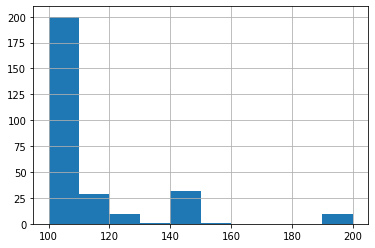

In [245]:
### There are 434 rows that have over 100% of presence
amph.loc[amph['percentage_presence']> 100,'percentage_presence'].hist()

In [246]:
len(amph.loc[amph['percentage_presence']> 100,'percentage_presence'])

281

In [218]:
dff = gadm[['GID_0','NAME_0','GID_1','NAME_1','MOL_ID','AREA_KM2','geometry']]
dff['reptiles']=np.nan
dff['amphibians']=np.nan
dff['mammals']=np.nan
dff['birds']=np.nan

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
for i in dff.MOL_ID:
    reptiles = []
    amphibians = []
    mammals = []
    birds = []
    
    ### REPTILES
    df = rept
    df = df.merge(gadm[['MOL_ID','AREA_KM2']])
    df['percentage_presence'] = round(df['SUM']/df['AREA_KM2']*100,2)
    for j in df[(df.MOL_ID== i)].SliceNumber.unique():
        sp_dict = {'SliceNumber':df[(df.MOL_ID== i) & (df.SliceNumber==j)].SliceNumber.values[0].astype(float),
               'percentage_presence':df[(df.MOL_ID== i) & (df.SliceNumber==j)].percentage_presence.values[0]}
        reptiles.append(sp_dict)
    dff.loc[dff['MOL_ID']==i,'reptiles'] =json.dumps(reptiles)
    
    ### AMPHIBIANS
    df = amph
    df = df.merge(gadm[['MOL_ID','AREA_KM2']])
    df['percentage_presence'] = round(df['SUM']/df['AREA_KM2']*100,2)
    for j in df[(df.MOL_ID== i)].SliceNumber.unique():
        sp_dict = {'SliceNumber':df[(df.MOL_ID== i) & (df.SliceNumber==j)].SliceNumber.values[0].astype(float),
               'percentage_presence':df[(df.MOL_ID== i) & (df.SliceNumber==j)].percentage_presence.values[0]}
        amphibians.append(sp_dict)
    dff.loc[dff['MOL_ID']==i,'amphibians'] =json.dumps(amphibians)
    
    ### BIRDS
    df = bird
    df = df.merge(gadm[['MOL_ID','AREA_KM2']])
    df['percentage_presence'] = round(df['SUM']/df['AREA_KM2']*100,2)
    for j in df[(df.MOL_ID== i)].SliceNumber.unique():
        sp_dict = {'SliceNumber':df[(df.MOL_ID== i) & (df.SliceNumber==j)].SliceNumber.values[0].astype(float),
               'percentage_presence':df[(df.MOL_ID== i) & (df.SliceNumber==j)].percentage_presence.values[0]}
        birds.append(sp_dict)
    dff.loc[dff['MOL_ID']==i,'birds'] =json.dumps(birds)
    
    ### MAMMALS
    df = mam
    df = df.merge(gadm[['MOL_ID','AREA_KM2']])
    df['percentage_presence'] = round(df['SUM']/df['AREA_KM2']*100,2)
    for j in df[(df.MOL_ID== i)].SliceNumber.unique():
        sp_dict = {'SliceNumber':df[(df.MOL_ID== i) & (df.SliceNumber==j)].SliceNumber.values[0].astype(float),
               'percentage_presence':df[(df.MOL_ID== i) & (df.SliceNumber==j)].percentage_presence.values[0]}
        mammals.append(sp_dict)
    dff.loc[dff['MOL_ID']==i,'mammals'] =json.dumps(mammals)
    print(f'finished MOL_ID ={i}')
    

In [224]:
dff.head()

,GID_0,NAME_0,GID_1,NAME_1,MOL_ID,AREA_KM2,geometry,reptiles,amphibians,mammals,birds
0,AFG,Afghanistan,AFG.1_1,Badakhshan,1,43692.210235,"POLYGON ((71.10155 35.95555, 71.08842 35.92924...","[{""SliceNumber"": 4.0, ""percentage_presence"": 0...","[{""SliceNumber"": 951.0, ""percentage_presence"":...",[],[]
1,AFG,Afghanistan,AFG.2_1,Badghis,2,20589.857163,"POLYGON ((63.09734 34.64551, 63.06237 34.69018...","[{""SliceNumber"": 9.0, ""percentage_presence"": 9...","[{""SliceNumber"": 1707.0, ""percentage_presence""...","[{""SliceNumber"": 399.0, ""percentage_presence"":...","[{""SliceNumber"": 26.0, ""percentage_presence"": ..."
2,AFG,Afghanistan,AFG.3_1,Baghlan,3,21120.261382,"POLYGON ((67.35538 34.88549, 67.33750 34.91966...","[{""SliceNumber"": 1.0, ""percentage_presence"": 5...",[],[],[]
3,AFG,Afghanistan,AFG.4_1,Balkh,4,17253.634668,"POLYGON ((66.42347 35.64057, 66.51625 35.67334...","[{""SliceNumber"": 9.0, ""percentage_presence"": 9...",[],"[{""SliceNumber"": 399.0, ""percentage_presence"":...","[{""SliceNumber"": 26.0, ""percentage_presence"": ..."
4,AFG,Afghanistan,AFG.5_1,Bamyan,5,14173.489095,"POLYGON ((66.65279 34.00322, 66.67175 34.03791...","[{""SliceNumber"": 1.0, ""percentage_presence"": 3...",[],"[{""SliceNumber"": 167.0, ""percentage_presence"":...","[{""SliceNumber"": 26.0, ""percentage_presence"": ..."


In [226]:
dff.to_file('/Users/tamarahuete/Documents/HALF_EARTH/gadm36_level1_Simplify_precalculated_crfs.shp')

In [228]:
dff[(dff['MOL_ID']==1)].reptiles[0]

'[{"SliceNumber": 4.0, "percentage_presence": 0.12}, {"SliceNumber": 9.0, "percentage_presence": 71.32}, {"SliceNumber": 327.0, "percentage_presence": 0.03}, {"SliceNumber": 1227.0, "percentage_presence": 0.27}, {"SliceNumber": 1229.0, "percentage_presence": 7.49}, {"SliceNumber": 1555.0, "percentage_presence": 0.17}, {"SliceNumber": 2527.0, "percentage_presence": 11.62}, {"SliceNumber": 3470.0, "percentage_presence": 5.37}, {"SliceNumber": 3737.0, "percentage_presence": 0.92}, {"SliceNumber": 3741.0, "percentage_presence": 13.08}, {"SliceNumber": 3747.0, "percentage_presence": 3.32}, {"SliceNumber": 3805.0, "percentage_presence": 0.1}, {"SliceNumber": 3808.0, "percentage_presence": 9.19}, {"SliceNumber": 3829.0, "percentage_presence": 16.62}, {"SliceNumber": 3832.0, "percentage_presence": 11.19}, {"SliceNumber": 4540.0, "percentage_presence": 26.08}, {"SliceNumber": 4939.0, "percentage_presence": 0.11}, {"SliceNumber": 5675.0, "percentage_presence": 4.22}, {"SliceNumber": 5854.0, "per